# Non-Myopic Bayesian Optimization: Towards Non-Trivial Horizons 
For the sake of simplicity, we'll focus first on 1D problems and then generalize of programming framework to hand nD problems.

## Questions & Concerns
- If we return functional objects, we can simulate having a handle on our Gaussian Process as it evolves in time cheaply by evaluating each instance
  on an as needed basis. The most costly thing would be having to keep track of the handles to such in some type of dictionary.

## What's Next?

- [x] Finish LaTeX on analytic formulation of expected improvement in 1d.
- [x] Write code to implement expected improvement in 1d.
- [ ] Once the BO loop can solve this problem in 1d, work on computing trajectories and add code to support such.

In [1]:
using Distributions
using LinearAlgebra
using Optim
using Plots
using Statistics
using Zygote

import Base.@kwdef

In [2]:
abstract type Kernel end

## Accessory and Utility Methods + Black Box Process
A pretty laborious thing to code is the construction of our covariances matrices with respect to different variates, so we abstract away this process. Provided that
you specify your kernel of choice and provide it access to a collection of both your variates, then we can easily construct such a matrix. We also accept a noise
parameter, however, I believe this should be encapsulated elsewhere (for storage purposes) because I'm sure we'll need access to it again.

Here, we assume that our `Black Box Process` is known, although, in practice, it isn't. We assume a strict analytical form, of which, we can sample from with or
without noise over the interval $[-1, 2]$.
$$
f_\sigma (x) = \alpha \cdot (-sin(3x) -x^2 + .7x) + \sigma \epsilon
$$
where $\alpha \in \mathbb{R}$ is a scale factor and $\epsilon \sim \mathcal{N}(0, 1)$


#### CovarianceMatrix
Arguments:
* kernel::Kernel: a kernel functor that evaluates the covariance between two vectors
* Xa::Array{Float64, 2}: a matrix of variates
* Xb::Array{Float64, 2}: a matrix of variates
* $\sigma$noise::Real: noise term 

Constructs a covariance matrix between the given matrices.

In [194]:
function blackBoxProcess(xloc::Float64; σnoise::Float64=.1)
    # Domain of interest (for f) is restricted to [-1, 2]
    scale_factor = 1.
    horizontal_shift = 0
    f(x; σ=σnoise) = scale_factor * (-sin(3x) - x^2 + .7x + horizontal_shift) + σ*randn()
    return f(xloc)
end

# Matrix will be xlength x ylength: every row corresponds to an element from x
# More generally, the covariance between two entities can be vector valued
function covarianceMatrix(kernel::Kernel, Xa::Array{Float64, 2}, Xb::Array{Float64, 2}; σnoise::Real=0.0)
    @assert size(Xa)[1] == size(Xb)[1]
    @assert isempty(methods(kernel)) == false
    
    # Kernel should be a function of two arguments
    xalength = size(Xa)[2] # rows here correspond to dimensionality
    xblength = size(Xb)[2]
    covMatrix = zeros(xalength, xblength)

    for xacol in 1:xalength
        for xbcol in 1:xblength
            δkronecker = xacol == xbcol ? σnoise^2 * 1 : 0
            covMatrix[xacol, xbcol] = kernel(Xa[:, xacol], Xb[:, xbcol]) + δkronecker
        end
    end

    return covMatrix
end

function toMatrix(x::Float64)
    return reshape([x], (1, 1))
end

toMatrix (generic function with 1 method)

## Kernels as Structs
Here, we represent support for each kernel as a struct. Each struct accepts hyperparameters, associated with the respective kernel, as named arguments
and returns a handle on the object. Each object is callable and represents computing $k(x_a, x_b)$. Every kernel has an output variance/scale factor associated with, which we'll call `variance`. We also take into account noisy situations as well which is denoted as `noise` and is squared
internally.

`Squared Exponential Kernel`: $k(x, x') = \nu^2 exp(-\frac{(x - x')^2}{2l^2}) + \sigma_{noise}^2 \delta_{xx'}$

### Design Choices
I want each kernel's hyperparameters to be name specified to avoid ambuguity with ordered.

In [195]:
@kwdef mutable struct SquaredExponential <: Kernel
    variance::Real # provided as ν²
    lengthscale::Real # provided as l
    noise::Real # provided as σ
    
    function SquaredExponential(variance, lengthscale, noise)
        @assert variance >= 0 "variance must be a positive real number"
        
        return new(variance, lengthscale, noise)
    end
end

SquaredExponential

In [196]:
SquaredExponential() = SquaredExponential(variance=1.0, lengthscale=1.0, noise=0.0)
SE() = SquaredExponential()

function (se::SquaredExponential)(x::Array{Float64, 1}, y::Array{Float64, 1})::Real
    δxx = Int8(x == y)
    r = x - y
    ρ = norm(r, 2)
    return se.variance * exp(-ρ^2 / 2*se.lengthscale^2) + δxx*se.noise^2
end

In [197]:
# Suppose we have some process and we have n known function evaluations
n = 2
d = 1
σnoise = 0.05

# D x n, D: dimensions, n: number of observations
X = round.(
    rand(Uniform(-1., 2.), d, n), 
    digits=4
) 
y = vec(blackBoxProcess.(X; σnoise=σnoise))

# Let's sample from our predictive distribution conditioned on our observations
# across the interval [-1, 2] to observe some reasonable functions
Xtrue = collect(-10.0:.1:10.0)
Xtrue = reshape(Xtrue, (1, length(Xtrue)))
ytrue = blackBoxProcess.(Xtrue; σnoise=0.0)

1×201 Array{Float64,2}:
 -107.988  -105.929  -103.803  -101.615  …  -88.2774  -90.0905  -92.012

## Gaussian Processes as Structs
It'd be very convenient for us to encapsulate information associated with GPs into a struct. It's immediately obvious, that the predictive mean and 
predictive variance rely on similar information and computing and storing such information multiple times is redundant and can become expensive in
higher dimensional settings. I'm making a design choice here of accepting the kernel and mean function as function objects instead of vectors. Multiple constructor methods will be supported, but for the time-being, we'll focus on one.

*Gaussian Process State*

`Mean Function`: a function like object representing the mean of the observations

`Covariance Function`: a function like object used to compute the covariance matrix between observations

`Cholesky Matrix`: from the cholesky factor, we should be able to reconstruct our covariance matrix since the cholesky factorization of a positive semi-definite matrix is 
unique.

`Cholesky Solve (alpha)`: $\alpha := L^T \backslash (L \backslash y)$,

### Gaussian Process Utility Methods
`Conditional`: conditioning the GP on inputs and targets should take the internal covariance function and compute the predictive mean and predictive variance
* Or, we compute the alpha term which is then used by our predictive variance and predictive mean. So, each time we return a handle on the predictive mean and predictive
  variance, we ensure that the alpha term has been computed (which will take place in conditional). We may

`Predictive Mean`: a function that accepts a GP

In [198]:
# Helper method for ensuring an object is callable
isCallable(f) = !isempty(methods(f))
const DataOrNothing{Type} = Union{Type, Nothing}

Union{Nothing, Type} where Type

In [199]:
@kwdef mutable struct GaussianProcess
    meanFunction
    covarianceFunction::Kernel
    choleskyFactor::DataOrNothing{AbstractMatrix{Float64}}
    choleskySolve::DataOrNothing{AbstractVector{Float64}}
    predictiveVariance
    predictiveMean
    
    function GaussianProcess(mean, kernel)
        @assert isCallable(mean) == true
        @assert isCallable(kernel) == true

        return new(
            mean,
            kernel,
            nothing,
            nothing,
            nothing,
            nothing
        )
    end
end

GaussianProcess

In [200]:
GP(mean, kernel) = GaussianProcess(mean, kernel)

# add a constructor method for accepting the other factors and returns a new copy
# of a GP

GP (generic function with 1 method)

In [201]:
function covarianceMatrix(gp::GaussianProcess)::Union{AbstractMatrix{Float64}, Nothing}
    if isnothing(gp.choleskyFactor) return nothing end
    return gp.choleskyFactor * gp.choleskyFactor'
end

covarianceMatrix (generic function with 2 methods)

In [202]:
covarianceMatrix(GP(()-> 0., SE()))

## Bayesian Optimization as Structs
In order to perform the iteration, efficient utilization of state is necessary. Abstracting away unnecessary state from our Gaussian Process is necessary. Mathematically,
a Gaussian Process is completely defined by it's mean function and covariance function. Thus, programmatically, we'll leave it the same. It does need data to perform useful
operations, so we'll provide that by wrapping the iteration into a Bayesian Optimization struct and maintaining supplementary state here.

*Bayesian Optimization State*

`Samples/Variates X`: We enforce that the observations provided are $\mathbb{R}^{D \times n}$, where $D := $ the dimensionality of the variates and $n := $ is the number of
observations.

`Values/Covariates y`: We further enforce that the observations are provided as column vector $v \in \mathbb{R}^{n}$

`Best Observation ybest`: Since we're usually dealing with sparse data initially, we find the best value from the given covariates.

In [203]:
@kwdef mutable struct BayesianOptimization
    gp::GaussianProcess
    X::DataOrNothing{AbstractMatrix{Float64}}
    y::DataOrNothing{AbstractVector{Float64}}
    ybest::Float64
    xi::Float64 # exploration parameter
    
    function BayesianOptimization(gp::GaussianProcess, X::Array{Float64, 2}, y::Array{Float64, 1})
        @assert size(X)[2] == length(y) "each variate must have a corresponding covariate:" # may cause issues when generalizing to vector valued functions
        
        return new(gp, X, y, maximum(y)) 
    end
end 

BayesianOptimization

In [204]:
BO(gp, X, y) = BayesianOptimization(gp, X, y)

BO (generic function with 1 method)

In [275]:
function sample(gp::GaussianProcess, xloc::Float64)
    # Want to sample from a multivariate normal which is centered at the predictive
    # mean with covariance matrix defined by the GPs kernel matrix
    # To generate a sample at location xloc, we must compute the predictive mean and predictive variance
    # at the location and sample from a mvn with mean and covariance specified as such
    μxloc = gp.predictiveMean(xloc)
    σxloc = gp.predictiveVariance(xloc)
    uninorm = Normal(μxloc, σxloc^2)
    return nsamples::Int64 -> rand(uninorm, nsamples)
end

# function pseudoConditional(gp::GaussianProcess, x::Array{Float64, 1})
    
# end

function conditional(bopt::BayesianOptimization, X::Array{Float64, 2}, y::Array{Float64, 1}, σnoise::Float64)
    priorData = bopt.X
    posteriorData = X
    priorDataCovariates = bopt.y
    posteriorDataCovariates = y
    
    if isnothing(bopt.gp.choleskyFactor) # initialize our model
        KXX = covarianceMatrix(bopt.gp.covarianceFunction, priorData, priorData; σnoise=σnoise) # bopt.gp.covarianceFunction.noise instead of σnoise
        KXX = Matrix(Hermitian(KXX))
        bopt.gp.choleskyFactor = cholesky(KXX).U'
    else # update our model
        L = bopt.gp.choleskyFactor
        KXX = Matrix(Hermitian(L*L'))
        KXS = covarianceMatrix(bopt.gp.covarianceFunction, priorData, posteriorData; σnoise=σnoise)
        KSS = covarianceMatrix(bopt.gp.covarianceFunction, posteriorData, posteriorData; σnoise=σnoise)
        KXplusS = [KXX KXS;
                   KXS' KSS]
        KXplusS = Matrix(Hermitian(KXplusS))
        bopt.gp.choleskyFactor = cholesky(KXplusS).U'
        # update bopt with new observations
        bopt.X = hcat(bopt.X, X)
        bopt.y = vcat(bopt.y, y)
        bopt.ybest = maximum(bopt.y)
    end
    
    L = bopt.gp.choleskyFactor
    bopt.gp.choleskySolve = L'\(L\bopt.y)
    
    # construct predictive mean function
    function μ(xtest)
        xtest = toMatrix(xtest)
        kxs = covarianceMatrix(bopt.gp.covarianceFunction, bopt.X, xtest; σnoise=σnoise)
        return dot(kxs, bopt.gp.choleskySolve)
    end
    
    bopt.gp.predictiveMean = μ
    
    # construct predictive variance function
    function σsquared(xtest)
        xtest = toMatrix(xtest)
        kxs = covarianceMatrix(bopt.gp.covarianceFunction, bopt.X, xtest; σnoise=σnoise)
        v = bopt.gp.choleskyFactor \ kxs
        kss = covarianceMatrix(bopt.gp.covarianceFunction, xtest, xtest; σnoise=σnoise)[1][1]
        return kss - dot(v, v)
    end
    
    bopt.gp.predictiveVariance = σsquared
    
    return
end

conditional (generic function with 1 method)

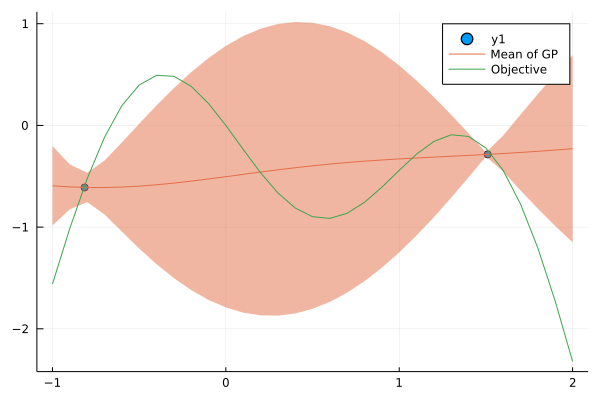

In [276]:
domain = -1.:.1:2.
zero_mean(x) = 0.
sekernel2 = SE()
gp2 = GP(zero_mean, sekernel2)
bopt2 = BayesianOptimization(gp2, X, y)
conditional(bopt2, X, y, σnoise)

scatter(bopt2.X', bopt2.y)
plot!(
    domain,
    bopt2.gp.predictiveMean.(domain),
    ribbon=2*sqrt.(bopt2.gp.predictiveVariance.(domain)),
    label="Mean of GP"
)
plot!(domain, blackBoxProcess.(domain; σnoise=0.0), label="Objective") # true objective
# bopt.gp.choleskySolve

## Seeking an Optimal Value via Expected Improvement
Thus far, we've been able to abstract away enough information about bayesian optimization in order to give us a relatively
seamless handle on computations of interest. Now, we turn our attention to minimizing our objective function via
expected improvement. As a brief aside, we'll derive the analytic representation of expected improvement below:

Mathematically, our improvement at x can be expressed as follows: $I(x) = max(Y - f^{*}, 0)$. Where
$Y \sim \mathcal{N}(\mu, \sigma^2)$ is the random variable that corresponds to the function value at x. Since $I$ is a random
variable, one can consider the average (expected) improvement (EI) to assess x.

$$
EI(x) = \mathbb{E}_{Y \sim \mathcal{N}(\mu, \sigma^2)}\left[ I(x) \right]
$$

With the reparameterization trick, $Y = \mu + \sigma \epsilon$ where $\epsilon \sim \mathcal{N}(0, 1)$, we have:

$$
EI(x) = \mathbb{E}_{\epsilon \sim \mathcal{N}(0, 1)}\left[ I(x) \right]
$$

which can be written as

$$
EI(x) = \int_{-\infty}^{\infty} I(x) \phi(\epsilon) d\epsilon
$$

This integral only has a value greater than 0 when $I(x) > 0$. 
$$
\therefore I(x) > 0 \Rightarrow EI(x) > 0 \\
\Updownarrow \\
\mu + \sigma \epsilon - f^{*} > 0 \Rightarrow EI(x) > 0 \\
\Updownarrow \\
\epsilon > \frac{f^{*} - \mu}{\sigma} \Rightarrow EI(x) > 0
$$

Now we solve for $EI(x)$.

\begin{align*}
EI(x) &= \int_{\frac{f^{*}-\mu}{\sigma}}^{\infty} (\mu + \sigma \epsilon - f^{*}) \phi(\epsilon) d\epsilon\\
&= (\mu - f^{*}) \left[ 1 - \Phi(\frac{f^{*} - \mu}{\sigma}) \right] + \sigma \phi(\frac{f^{*} - \mu}{\sigma})
\end{align*}

But, $EI(x)$ is piecewise, therefore we have the following:

$$
EI(\textbf{x}) =
\left\{
\begin{array}{ll}
      (\mu(\textbf{x}) - f(\textbf{x}^*) - \xi)\Phi(Z) + \sigma(\textbf{x})\phi(Z) & \sigma(\textbf{x}) \gt 0 \\
      0 & \sigma(\textbf{x}) = 0 \\
\end{array} 
\right.
$$

where

$$
Z =
\left\{
\begin{array}{ll}
      \frac{\mu(\textbf{x}) - f(\textbf{x}^*) - \xi}{\sigma(\textbf{x})} & \sigma(\textbf{x}) \gt 0 \\
      0 & \sigma(\textbf{x}) = 0 \\
\end{array} 
\right.
$$

In [291]:
function z(x, bopt::BayesianOptimization)
    σ̂(xa) = sqrt(abs(bopt.gp.predictiveVariance(xa)))
    μ̂(xa) = bopt.gp.predictiveMean(xa)
    f⁺ = bopt.ybest
    ξ = .1
    return σ̂(x) > 0 ? (μ̂(x) - f⁺ - ξ) / σ̂(x) : 0
end

function ei(x, bopt::BayesianOptimization)
    z_eval = z(x, bopt)
    normal = Normal()
    normal_cdf_at_z = cdf(normal, z_eval)
    normal_pdf_at_z = pdf(normal, z_eval)
    σ̂(xa) = abs(sqrt(bopt.gp.predictiveVariance(xa)))
    μ̂(xa) = bopt.gp.predictiveMean(xa)
    f⁺ = bopt.ybest
    ξ = .1
    
    return σ̂(x) > 0 ? (μ̂(x) - f⁺ - ξ) * normal_cdf_at_z + σ̂(x)*normal_pdf_at_z : 0
end

ei (generic function with 1 method)

### Test Loop

In [228]:
# Iteratively build our plots while conditioning on new data

# Setup
# Suppose we have some process and we have n known function evaluations
n = 2
d = 1
σnoise = 0.05
domain = -1.:.1:2.

# Variates and Covariates for initialization
X = round.(
    rand(Uniform(-10.0, 10.0), d, n), 
    digits=4
) 
y = vec(blackBoxProcess.(X; σnoise=σnoise))

# Initialize our models
zero_mean(x) = 0.
sekernel = SE()
gp = GP(zero_mean, sekernel)
bopt = BayesianOptimization(gp, X, y)
conditional(bopt, X, y, σnoise)

# Keep track of our plots
obsAndObjAndGpPlots = [plot(domain, blackBoxProcess.(domain; σnoise=0.0), label="Objective", legend=:outertopleft)]
plot!(obsAndObjAndGpPlots[1], bopt.X', bopt.y, seriestype=:scatter)
plot!(
    obsAndObjAndGpPlots[1],
    domain,
    bopt.gp.predictiveMean.(domain),
    ribbon=2*sqrt.(bopt.gp.predictiveVariance.(domain)),
    label="μ ± 2σ (GP)"
);

# A few iterations of BO
BUDGET = 20
for budget = 1:BUDGET
    # Randomly sample without EI
    Xnew = round.(
        rand(Uniform(-10.0, 10.0), d, 1),
        digits=4
    )
    ynew = vec(blackBoxProcess.(Xnew; σnoise=σnoise))
    
    # Update model
    conditional(bopt, Xnew, ynew, σnoise)
    
    # Append plot
    push!(obsAndObjAndGpPlots, plot(domain, blackBoxProcess.(domain; σnoise=0.0), label="Objective", legend=:outertopleft))
    plot!(obsAndObjAndGpPlots[budget+1], bopt.X', bopt.y, seriestype=:scatter)
    plot!(
        obsAndObjAndGpPlots[budget+1],
        domain,
        bopt.gp.predictiveMean.(domain),
        ribbon=2sqrt.(bopt.gp.predictiveVariance.(domain)),
        label="μ ± 2σ (GP)",
    )
end

In [160]:
for i = 1:BUDGET
    savefig(obsAndObjAndGpPlots[i], "model0$(i).png")
end
# savefig(obsAndObjAndGpPlots[1], "pic.png")
# plot(obsAndObjAndGpPlots[1])

# Bayesian Optimization w/Expected Improvement

In [295]:
# Iteratively build our plots while conditioning on new data

# Setup
# Suppose we have some process and we have n known function evaluations
n = 2
d = 1
σnoise = 0.05
domain = -1.:.1:2.

# Variates and Covariates for initialization
X = round.(
    rand(Uniform(domain[1], domain[end]), d, n), 
    digits=4
) 
y = vec(blackBoxProcess.(X; σnoise=σnoise))

# Initialize our models
zero_mean(x) = 0.
sekernel = SE()
gp = GP(zero_mean, sekernel)
bopt = BayesianOptimization(gp, X, y)
conditional(bopt, X, y, σnoise)

# Keep track of our plots
obsAndObjAndGpPlots = [plot(domain, blackBoxProcess.(domain; σnoise=0.0), label="Objective", legend=:outertopleft)]
plot!(obsAndObjAndGpPlots[1], bopt.X', bopt.y, seriestype=:scatter)
plot!(
    obsAndObjAndGpPlots[1],
    domain,
    bopt.gp.predictiveMean.(domain),
    ribbon=2*sqrt.(abs.(bopt.gp.predictiveVariance.(domain))),
    label="μ ± 2σ (GP)"
);

# A few iterations of BO
BUDGET = 20
for budget = 1:BUDGET
    # Find new sample by solving ∇EI = 0
    einow(x) = ei(x, bopt)
    result = optimize(x -> -einow(first(x)), domain[1], domain[end])
    maximizer = [Optim.minimizer(result)]
    
    # Sample based on recommendation
    Xnew = reshape(maximizer, (1, 1))
    ynew = vec(blackBoxProcess.(Xnew; σnoise=σnoise))
    
    # Update model
    conditional(bopt, Xnew, ynew, σnoise)
    
    # Append plot
    push!(obsAndObjAndGpPlots, plot(domain, blackBoxProcess.(domain; σnoise=0.0), label="Objective", legend=:outertopleft))
    plot!(obsAndObjAndGpPlots[budget+1], bopt.X', bopt.y, seriestype=:scatter)
    plot!(
        obsAndObjAndGpPlots[budget+1],
        domain,
        bopt.gp.predictiveMean.(domain),
        ribbon=2sqrt.(abs.(bopt.gp.predictiveVariance.(domain))),
        label="μ ± 2σ (GP)",
    )
    
    println(bopt.ybest)
end

-0.702384620765038
-0.702384620765038
-0.3034320047270342
-0.08592815446987874
0.5415606096344738
0.5415606096344738
0.5415606096344738
0.5415606096344738
0.5415606096344738
0.5415606096344738
0.558693983594186
0.558693983594186
0.558693983594186
0.558693983594186
0.558693983594186
0.558693983594186
0.558693983594186
0.558693983594186
0.558693983594186
0.558693983594186


In [296]:
for i = 1:BUDGET
    savefig(obsAndObjAndGpPlots[i], "model0$(i).png")
end

In [282]:
bopt.ybest

0.3377671437990332

# Chicken Scratch Below Here

In [70]:
using Optim
using Zygote

┌ Info: Precompiling Optim [429524aa-4258-5aef-a3af-852621145aeb]
└ @ Base loading.jl:1278


In [244]:
x0 = [0.]
result = optimize(x -> -eibar(first(x)), -1.0, 2.0)
optimizer = Optim.minimizer(result)

1.878818517601695

LoadError: [91mMethodError: no method matching Array{T,2} where T(::Array{Float64,1})[39m
[91m[0mClosest candidates are:[39m
[91m[0m  Array{T,2} where T(::AbstractArray{S,N}) where {S, N} at boot.jl:428[39m
[91m[0m  Array{T,2} where T([91m::SymTridiagonal{T,V} where V<:AbstractArray{T,1}[39m) where T at /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.5/LinearAlgebra/src/tridiag.jl:141[39m
[91m[0m  Array{T,2} where T([91m::Tridiagonal{T,V} where V<:AbstractArray{T,1}[39m) where T at /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.5/LinearAlgebra/src/tridiag.jl:582[39m
[91m[0m  ...[39m

In [209]:
xinit = [0.]
einow(x) = -ei(first(x), bopt)
result = optimize(einow, xinit, LBFGS())
Optim.minimizer(result)

1-element Array{Float64,1}:
 0.7789053218266301